In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error


In [2]:
df = pd.read_csv('poluicao.csv')
df = df.dropna()
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [3]:
# target -> pm2.5
df = df.drop(columns=['No', 'year', 'month', 'day', 'hour', 'cbwd'])
df

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,129.0,-16,-4.0,1020.0,1.79,0,0
25,148.0,-15,-4.0,1020.0,2.68,0,0
26,159.0,-11,-5.0,1021.0,3.57,0,0
27,181.0,-7,-5.0,1022.0,5.36,1,0
28,138.0,-7,-5.0,1022.0,6.25,2,0
...,...,...,...,...,...,...,...
43819,8.0,-23,-2.0,1034.0,231.97,0,0
43820,10.0,-22,-3.0,1034.0,237.78,0,0
43821,10.0,-22,-3.0,1034.0,242.70,0,0
43822,8.0,-22,-4.0,1034.0,246.72,0,0


In [4]:
train_df = df.values
train_df

array([[129.  , -16.  ,  -4.  , ...,   1.79,   0.  ,   0.  ],
       [148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
       [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
       ...,
       [ 10.  , -22.  ,  -3.  , ..., 242.7 ,   0.  ,   0.  ],
       [  8.  , -22.  ,  -4.  , ..., 246.72,   0.  ,   0.  ],
       [ 12.  , -21.  ,  -3.  , ..., 249.85,   0.  ,   0.  ]])

In [6]:
target_train = train_df[:, 0].reshape(-1, 1)
target_train

array([[129.],
       [148.],
       [159.],
       ...,
       [ 10.],
       [  8.],
       [ 12.]])

In [7]:
scaler = MinMaxScaler()
scaler_train_df = scaler.fit_transform(train_df)
scaler_train_df

array([[0.12977867, 0.35294118, 0.24590164, ..., 0.00237151, 0.        ,
        0.        ],
       [0.14889336, 0.36764706, 0.24590164, ..., 0.00394662, 0.        ,
        0.        ],
       [0.15995976, 0.42647059, 0.2295082 , ..., 0.00552173, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.26470588, 0.26229508, ..., 0.42873071, 0.        ,
        0.        ],
       [0.00804829, 0.26470588, 0.24590164, ..., 0.43584525, 0.        ,
        0.        ],
       [0.01207243, 0.27941176, 0.26229508, ..., 0.44138468, 0.        ,
        0.        ]])

In [10]:
X = []
y = []

for i in range(10, scaler_train_df.shape[0]):
    X.append(scaler_train_df[i-10:i,1:7]) # here we catch forecasters
    y.append(scaler_train_df[i, 0]) # here we catch labels


X = np.array(X)
y = np.array(y)

In [12]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [14]:
Dataset

torch.utils.data.dataset.Dataset

In [17]:
dataset = torch.utils.data.TensorDataset(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [19]:
class regressor_LSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm1 = nn.LSTM(input_size = 6, hidden_size=128)
        self.lstm2 = nn.LSTM(input_size = 128, hidden_size=64)

        self.dropout = nn.Dropout(p=0.3)

        self.lstm3 = nn.LSTM(input_size = 64, hidden_size=32, dropout=0.3)

        self.linear = nn.Linear(in_features= 32, out_features=1)

    def forward(self, X):

        X = X.permute(1, 0, 2)

        X, _ = self.lstm1(X)
        X = self.dropout(X)

        X, _ = self.lstm2(X)
        X = self.dropout(X)

        X, _ = self.lstm3(X)
        X = self.dropout(X)


        X = self.linear(X)

        return X

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
regressor = regressor_LSTM().to(device)
optimizer = optim.Adam(regressor.parameters(), lr=0.001)
criterion = nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [22]:
ES_MIN_DELTA = 1e-10
ES_PATIENCE = 10
RLR_FACTOR = 0.2
RLR_PATIENCE = 5

min_loss = np.inf

In [24]:
for epoch in range(100):
    running_loss = 0.
    running_mae = 0.

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = regressor(inputs)

        outputs = outputs[-1]

        outputs = outputs.view(*labels.shape)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        mae = mean_absolute_error(labels.detach().cpu().numpy().flatten(), outputs.detach().cpu().numpy().flatten())
        running_mae += mae

        print(f'Epoch {epoch+1}/{100}, Batch {i+1}/{len(loader)}, Loss: {loss.item():.4f}, MAE: {mae:.4f}')

    epoch_loss = running_loss / len(loader)
    epoch_mae = running_mae / len(loader)

    print(f'Epoch {epoch+1}/{100}, Loss: {epoch_loss:.4f}, MAE: {epoch_mae:.4f}')

    if running_loss < min_loss:
        print(f'**Cost function reduced from {min_loss} to {running_loss}**')
        torch.save(regressor.state_dict(), 'model.pth')
        min_loss = running_loss
        es_patience = 0
        rlr_patience = 0

    else:
        print("**Cost does not decrease**")

        if running_loss - min_loss >= ES_MIN_DELTA:
            es_patience += 1
            if es_patience >= ES_PATIENCE:
                print(f'Early stopping at epoch {epoch+1}')
                break

        rlr_patience += 1
        if rlr_patience == RLR_PATIENCE:
            print('-- Criterion of learning rate reduced achieved, reducing LR. --')

            for param_group in optimizer.param_groups:
                param_group['lr'] *= RLR_FACTOR

            rlr_patience = 0


A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 93/100, Batch 241/653, Loss: 0.0026, MAE: 0.0353
Epoch 93/100, Batch 242/653, Loss: 0.0034, MAE: 0.0411
Epoch 93/100, Batch 243/653, Loss: 0.0017, MAE: 0.0304
Epoch 93/100, Batch 244/653, Loss: 0.0035, MAE: 0.0391
Epoch 93/100, Batch 245/653, Loss: 0.0017, MAE: 0.0288
Epoch 93/100, Batch 246/653, Loss: 0.0026, MAE: 0.0362
Epoch 93/100, Batch 247/653, Loss: 0.0028, MAE: 0.0367
Epoch 93/100, Batch 248/653, Loss: 0.0030, MAE: 0.0381
Epoch 93/100, Batch 249/653, Loss: 0.0028, MAE: 0.0387
Epoch 93/100, Batch 250/653, Loss: 0.0039, MAE: 0.0452
Epoch 93/100, Batch 251/653, Loss: 0.0017, MAE: 0.0320
Epoch 93/100, Batch 252/653, Loss: 0.0028, MAE: 0.0361
Epoch 93/100, Batch 253/653, Loss: 0.0038, MAE: 0.0451
Epoch 93/100, Batch 254/653, Loss: 0.0015, MAE: 0.0285
Epoch 93/100, Batch 255/653, Loss: 0.0032, MAE: 0.0412
Epoch 93/100, Batch 256/653, Loss: 0.0018, MAE: 0.0291
Epoch 93/100, Batch 257/653, Loss: 0.0038, MAE: 0.0416
Epoch 

In [25]:
regressor.eval()

regressor_LSTM(
  (lstm1): LSTM(6, 128)
  (lstm2): LSTM(128, 64)
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm3): LSTM(64, 32, dropout=0.3)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [28]:
forecast = regressor(X.to(device))

In [29]:
forecast = forecast[-1]
forecast = forecast.detach().cpu().numpy().reshape(-1,1)

In [30]:
normalizer = MinMaxScaler()
normalizer.fit(target_train)

forecast = normalizer.inverse_transform(forecast)

In [31]:
forecast.mean(), target_train.mean()

(99.4855, 98.61321455085375)

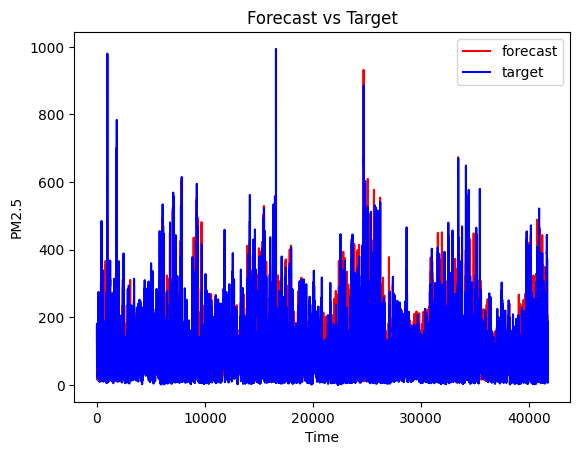

In [32]:
plt.plot(forecast, label='forecast', color='red')
plt.plot(target_train, label='target', color='blue')
plt.title('Forecast vs Target')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()
